2025-07-04 14:25:38,320 - INFO - Starting XGBoost model training with combined embeddings...
2025-07-04 14:25:38,321 - INFO - Loading iFeature_AAC embeddings...
2025-07-04 14:25:38,322 - INFO - Loading and extracting features for aac from ../data/embeddings/iFeature_AAC.csv...
2025-07-04 14:25:38,332 - INFO - Class distribution: Class 0: 859, Class 1: 861
2025-07-04 14:25:38,333 - INFO - iFeature_AAC dimensions: (1720, 20)
2025-07-04 14:25:38,333 - INFO - Loading Kidera_encoded embeddings...
2025-07-04 14:25:38,333 - INFO - Loading and extracting features for kidera from ../data/embeddings/Kidera_encoded.csv...
2025-07-04 14:25:38,359 - INFO - Class distribution: Class 0: 859, Class 1: 861
2025-07-04 14:25:38,360 - INFO - Kidera_encoded dimensions: (1720, 10)
2025-07-04 14:25:38,362 - INFO - Loading BLOSUM62_encoded embeddings...
2025-07-04 14:25:38,363 - INFO - Loading and extracting features for blosum from ../data/embeddings/BLOSUM62_encoded.csv...
2025-07-04 14:25:38,370 - INFO - C

Fitting 5 folds for each of 48 candidates, totalling 240 fits


2025-07-04 14:25:41,554 - INFO - Best XGBoost parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
2025-07-04 14:25:41,554 - INFO - Best XGBoost CV ROC AUC: 0.8738
2025-07-04 14:25:41,559 - INFO - 
--- XGBoost (Test) Results ---
2025-07-04 14:25:41,559 - INFO - Accuracy: 0.8186
2025-07-04 14:25:41,560 - INFO - F1-score (Class 0): 0.8125
2025-07-04 14:25:41,560 - INFO - F1-score (Class 1): 0.8243
2025-07-04 14:25:41,560 - INFO - F1-score (Macro Avg): 0.8184
2025-07-04 14:25:41,561 - INFO - Precision: 0.7991
2025-07-04 14:25:41,561 - INFO - Recall: 0.8512
2025-07-04 14:25:41,561 - INFO - ROC AUC: 0.8973
2025-07-04 14:25:41,562 - INFO - Confusion Matrix:
[[169  46]
 [ 32 183]]
2025-07-04 14:25:41,615 - INFO - Confusion matrix saved to '../images/information/xgboost_confusion_matrix.png'


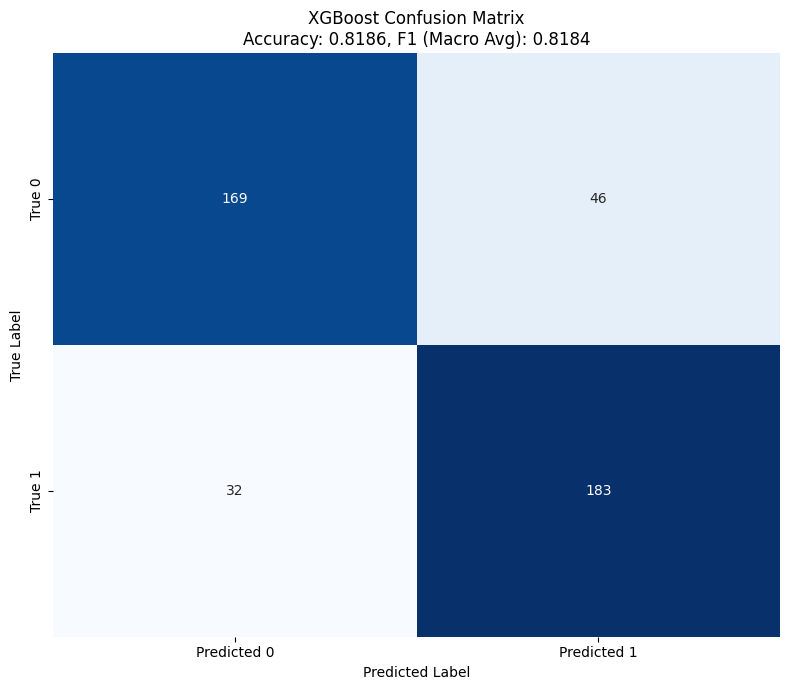

2025-07-04 14:25:41,656 - INFO - XGBoost model and artifacts saved to './models/xgboost_model'


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from xgboost import XGBClassifier
import sys
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import random
import joblib
import os
from tqdm import tqdm

# --- Configuration ---
# Defines various parameters for data loading, model training, and hyperparameter grids.
config = {
    'aac_data_path': '../data/embeddings/iFeature_AAC.csv',
    'kidera_data_path': '../data/embeddings/Kidera_encoded.csv',
    'blosum_data_path': '../data/embeddings/BLOSUM62_encoded.csv',
    'intensity_threshold': 207500,
    'test_size': 0.25,
    'random_state': 42,
    'feature_selection_ratio': 0.8, # Ratio of features to select using SelectKBest
    'xgb_param_grid': { # Hyperparameter grid for XGBoost GridSearchCV
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 200],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
}

# --- Seed Setting ---
def set_seed(seed: int) -> None:
    """
    Sets the random seed for reproducibility across numpy and random.
    """
    np.random.seed(seed)
    random.seed(seed)

# Initialize logging
set_seed(config['random_state'])
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Data Loading and Preprocessing ---
def load_and_extract_features(data_path: str, intensity_threshold: int, embedding_type: str) -> tuple[np.ndarray, np.ndarray]:
    """
    Loads a CSV file, extracts features, and creates a binary target variable
    based on an intensity threshold.
    """
    logging.info(f"Loading and extracting features for {embedding_type} from {data_path}...")
    try:
        df = pd.read_csv(data_path)
    except FileNotFoundError:
        logging.error(f"Error: Data file not found at {data_path}. Please check the path.")
        sys.exit(1) # Exit if file is not found
    except Exception as e:
        logging.error(f"Error loading CSV file: {e}")
        sys.exit(1) # Exit on other CSV loading errors

    if df.empty:
        logging.error("Error: Loaded CSV file is empty. No data to process.")
        sys.exit(1) # Exit if DataFrame is empty

    # Feature column selection based on embedding type
    if embedding_type == 'aac':
        feature_columns = [col for col in df.columns if len(col) == 1 and 'A' <= col <= 'Z' and col not in ['B', 'J', 'O', 'U', 'X', 'Z']]
        if not feature_columns:
            logging.warning("No standard single-letter AAC columns found. Attempting to use all columns except 'Intensity'.")
            feature_columns = [col for col in df.columns if col != 'Intensity']
        X = df.loc[:, feature_columns].values.astype(np.float32)
    elif embedding_type == 'kidera':
        X = df.loc[:, "KF1": "KF10"].values.astype(np.float32)
    elif embedding_type == 'blosum':
        blosum_cols = [col for col in df.columns if col.startswith('BLOSUM62_')]
        X = df.loc[:, blosum_cols].values.astype(np.float32)
    else:
        logging.error(f"Unknown embedding_type: {embedding_type}. Supported types are 'aac', 'kidera', and 'blosum'.")
        sys.exit(1) # Exit on unknown embedding type

    if 'Intensity' not in df.columns:
        logging.error("Error: 'Intensity' column not found in the CSV. Required for target variable creation.")
        sys.exit(1) # Exit if 'Intensity' column is missing

    # Create binary target variable based on threshold
    y_class = (df['Intensity'] > intensity_threshold).astype(int).values
    class_counts = np.bincount(y_class)
    logging.info(f"Class distribution: Class 0: {class_counts[0]}, Class 1: {class_counts[1]}")

    return X, y_class

def select_features(X_train, y_train, X_test, k_ratio=0.8):
    """
    Performs feature selection using SelectKBest with mutual_info_classif.
    Fits on training data and transforms training and test sets.
    """
    k = int(X_train.shape[1] * k_ratio) # Determine number of features to select
    if k == 0: # Ensure at least one feature is selected if k_ratio leads to 0
        k = 1
    elif k > X_train.shape[1]: # Do not select more features than available
        k = X_train.shape[1]

    selector = SelectKBest(mutual_info_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    logging.info(f"Selected {k} features using mutual information from {X_train.shape[1]} original features")
    return X_train_selected, X_test_selected, selector

def create_and_scale_splits_for_traditional_models(X: np.ndarray, y: np.ndarray, test_size: float, random_state: int) -> tuple:
    """
    Splits the data into training and test sets, and scales them using StandardScaler.
    The scaler is fitted only on the training data.
    """
    sss_test = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(sss_test.split(X, y))
    X_train_raw, X_test_raw = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_test_scaled = scaler.transform(X_test_raw)

    logging.info(f"Train dataset size: {len(X_train_scaled)}")
    logging.info(f"Test dataset size: {len(X_test_scaled)}")
    logging.info("Data scaled using StandardScaler (fitted on training data)")
    
    return X_train_scaled, y_train, X_test_scaled, y_test, scaler

# --- Evaluation Functions ---
def evaluate_classifier_metrics(y_true: np.ndarray, y_pred: np.ndarray, y_prob: np.ndarray = None, model_name: str = "Model") -> tuple:
    """
    Calculates and logs common classification metrics (accuracy, F1, precision, recall, ROC AUC, confusion matrix).
    Reports F1-score for each class separately.
    """
    accuracy = accuracy_score(y_true, y_pred)
    f1_per_class = f1_score(y_true, y_pred, average=None) # F1-score for each class
    f1_macro = f1_score(y_true, y_pred, average='macro') # Macro F1 for overall understanding
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    roc_auc = np.nan # Initialize ROC AUC to NaN
    if y_prob is not None and len(np.unique(y_true)) > 1: # ROC AUC requires probabilities and at least two classes
        try:
            roc_auc = roc_auc_score(y_true, y_prob)
        except ValueError as e:
            logging.warning(f"Error computing ROC AUC for {model_name}: {e}") # Log if ROC AUC cannot be computed

    logging.info(f"\n--- {model_name} Results ---")
    logging.info(f"Accuracy: {accuracy:.4f}")
    logging.info(f"F1-score (Class 0): {f1_per_class[0]:.4f}")
    logging.info(f"F1-score (Class 1): {f1_per_class[1]:.4f}")
    logging.info(f"F1-score (Macro Avg): {f1_macro:.4f}")
    logging.info(f"Precision: {precision:.4f}")
    logging.info(f"Recall: {recall:.4f}")
    logging.info(f"ROC AUC: {roc_auc:.4f}")
    logging.info(f"Confusion Matrix:\n{cm}")

    return accuracy, f1_macro, precision, recall, roc_auc, cm

# --- Main Script Execution (XGBoost Only) ---
def main():
    logging.info("Starting XGBoost model training with combined embeddings...")

    # Load and preprocess data from various embedding types
    logging.info("Loading iFeature_AAC embeddings...")
    X_aac, y_class_aac = load_and_extract_features(config['aac_data_path'], config['intensity_threshold'], 'aac')
    logging.info(f"iFeature_AAC dimensions: {X_aac.shape}")

    logging.info("Loading Kidera_encoded embeddings...")
    X_kidera, y_class_kidera = load_and_extract_features(config['kidera_data_path'], config['intensity_threshold'], 'kidera')
    logging.info(f"Kidera_encoded dimensions: {X_kidera.shape}")

    logging.info("Loading BLOSUM62_encoded embeddings...")
    X_blosum, y_class_blosum = load_and_extract_features(config['blosum_data_path'], config['intensity_threshold'], 'blosum')
    logging.info(f"BLOSUM62_encoded dimensions: {X_blosum.shape}")

    # Verify target consistency across different embedding files
    if not (np.array_equal(y_class_aac, y_class_kidera) and np.array_equal(y_class_aac, y_class_blosum)):
        logging.error("Target variables from different embeddings are not identical. Check input data alignment.")
        sys.exit(1) # Exit if targets don't match
    y_class = y_class_aac # Use one of them as the definitive target

    # Combine features horizontally
    X_combined = np.hstack((X_aac, X_kidera, X_blosum))
    logging.info(f"Combined feature dimensions: {X_combined.shape}")

    # Create data splits and apply global scaling
    X_train_scaled, y_train, X_test_scaled, y_test, scaler_global = \
        create_and_scale_splits_for_traditional_models(X_combined, y_class, config['test_size'], config['random_state'])

    # Apply feature selection to the scaled data
    X_train_selected, X_test_selected, feature_selector = \
        select_features(X_train_scaled, y_train, X_test_scaled, config['feature_selection_ratio'])
    
    # Train XGBoost Classifier
    logging.info("\nTraining XGBoost with combined embeddings...")
    # Adjust scale_pos_weight for imbalanced classes
    # It's calculated as count_negative_samples / count_positive_samples
    unique_classes, counts = np.unique(y_train, return_counts=True)
    class_0_count = counts[0] if 0 in unique_classes else 0
    class_1_count = counts[1] if 1 in unique_classes else 0
    
    scale_pos_weight_value = 1.0 # Default to 1 if no positive samples or division by zero
    if class_1_count > 0:
        scale_pos_weight_value = class_0_count / class_1_count
    
    logging.info(f"XGBoost scale_pos_weight: {scale_pos_weight_value:.4f}")

    # Removed 'use_label_encoder=False' as it's deprecated and causes a warning
    xgb_model = XGBClassifier(random_state=config['random_state'], 
                              eval_metric='logloss',
                              scale_pos_weight=scale_pos_weight_value) # Handle class imbalance
    
    xgb_grid_search = GridSearchCV(xgb_model, config['xgb_param_grid'], cv=5,
                                  scoring='roc_auc', verbose=1, n_jobs=-1)
    xgb_grid_search.fit(X_train_selected, y_train) # Train on the main training set
    best_xgb_model = xgb_grid_search.best_estimator_
    logging.info(f"Best XGBoost parameters: {xgb_grid_search.best_params_}")
    logging.info(f"Best XGBoost CV ROC AUC: {xgb_grid_search.best_score_:.4f}")

    # Evaluate XGBoost on the test set
    xgb_test_probs = best_xgb_model.predict_proba(X_test_selected)[:, 1]
    xgb_test_preds = (xgb_test_probs > 0.5).astype(int) # Threshold at 0.5 for binary prediction

    xgb_acc, xgb_f1_macro, xgb_prec, xgb_rec, xgb_roc_auc, xgb_cm = evaluate_classifier_metrics(
        y_test, xgb_test_preds, xgb_test_probs, "XGBoost (Test)"
    )

    # Plot confusion matrix for XGBoost
    fig, ax = plt.subplots(figsize=(8, 7))
    sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'], 
                yticklabels=['True 0', 'True 1'], ax=ax)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title(f"XGBoost Confusion Matrix\nAccuracy: {xgb_acc:.4f}, F1 (Macro Avg): {xgb_f1_macro:.4f}")
    
    plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
    plot_save_path = '../images/information/xgboost_confusion_matrix.png'
    os.makedirs(os.path.dirname(plot_save_path), exist_ok=True) # Ensure images directory exists
    plt.savefig(plot_save_path) # Save the plot
    logging.info(f"Confusion matrix saved to '{plot_save_path}'")
    plt.show() # Display the plot

    # Save trained XGBoost model and artifacts
    models_dir = './models/xgboost_model'
    os.makedirs(models_dir, exist_ok=True) # Create directory if it doesn't exist
    
    joblib.dump(best_xgb_model, os.path.join(models_dir, 'best_xgb_model.pkl'))
    joblib.dump(scaler_global, os.path.join(models_dir, 'scaler.pkl')) # Save the scaler
    joblib.dump(feature_selector, os.path.join(models_dir, 'feature_selector.pkl')) # Save the feature selector
    
    logging.info(f"XGBoost model and artifacts saved to '{models_dir}'")

if __name__ == "__main__":
    main()